# Импорты

In [ ]:
from pathlib import Path
from typing import Any

import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from mba.src import business, modeling, transforms, vis
from mba.src.const import DATA_PATH
from mba.src.transforms import PandasTransformer
from tqdm import tqdm

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

# Датасет

### Загрузить в pandas

In [ ]:
loan_data = pd.read_csv(DATA_PATH)
print(loan_data.to_string())

      лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  бизнес         сумма                    сбор        срок  амортизация  только_процент  один_платеж  стоимость_имущества проживание тип_залога  тип_кредита  кредитный_рейтинг возраст  прямой_залог  дефолт                                                                                                                                                                                                                                                                                                                                                        речь
0               0.0    м  3.0   0.0                 1.0             NaN     0.0  1.747653e+05                  normal  245.885949          0.0             0.0          0.0         2.444881e+05        осн        дом          2.0         709.508335   55-64           1.0       0                                                                                                   

### Наличие аномалий

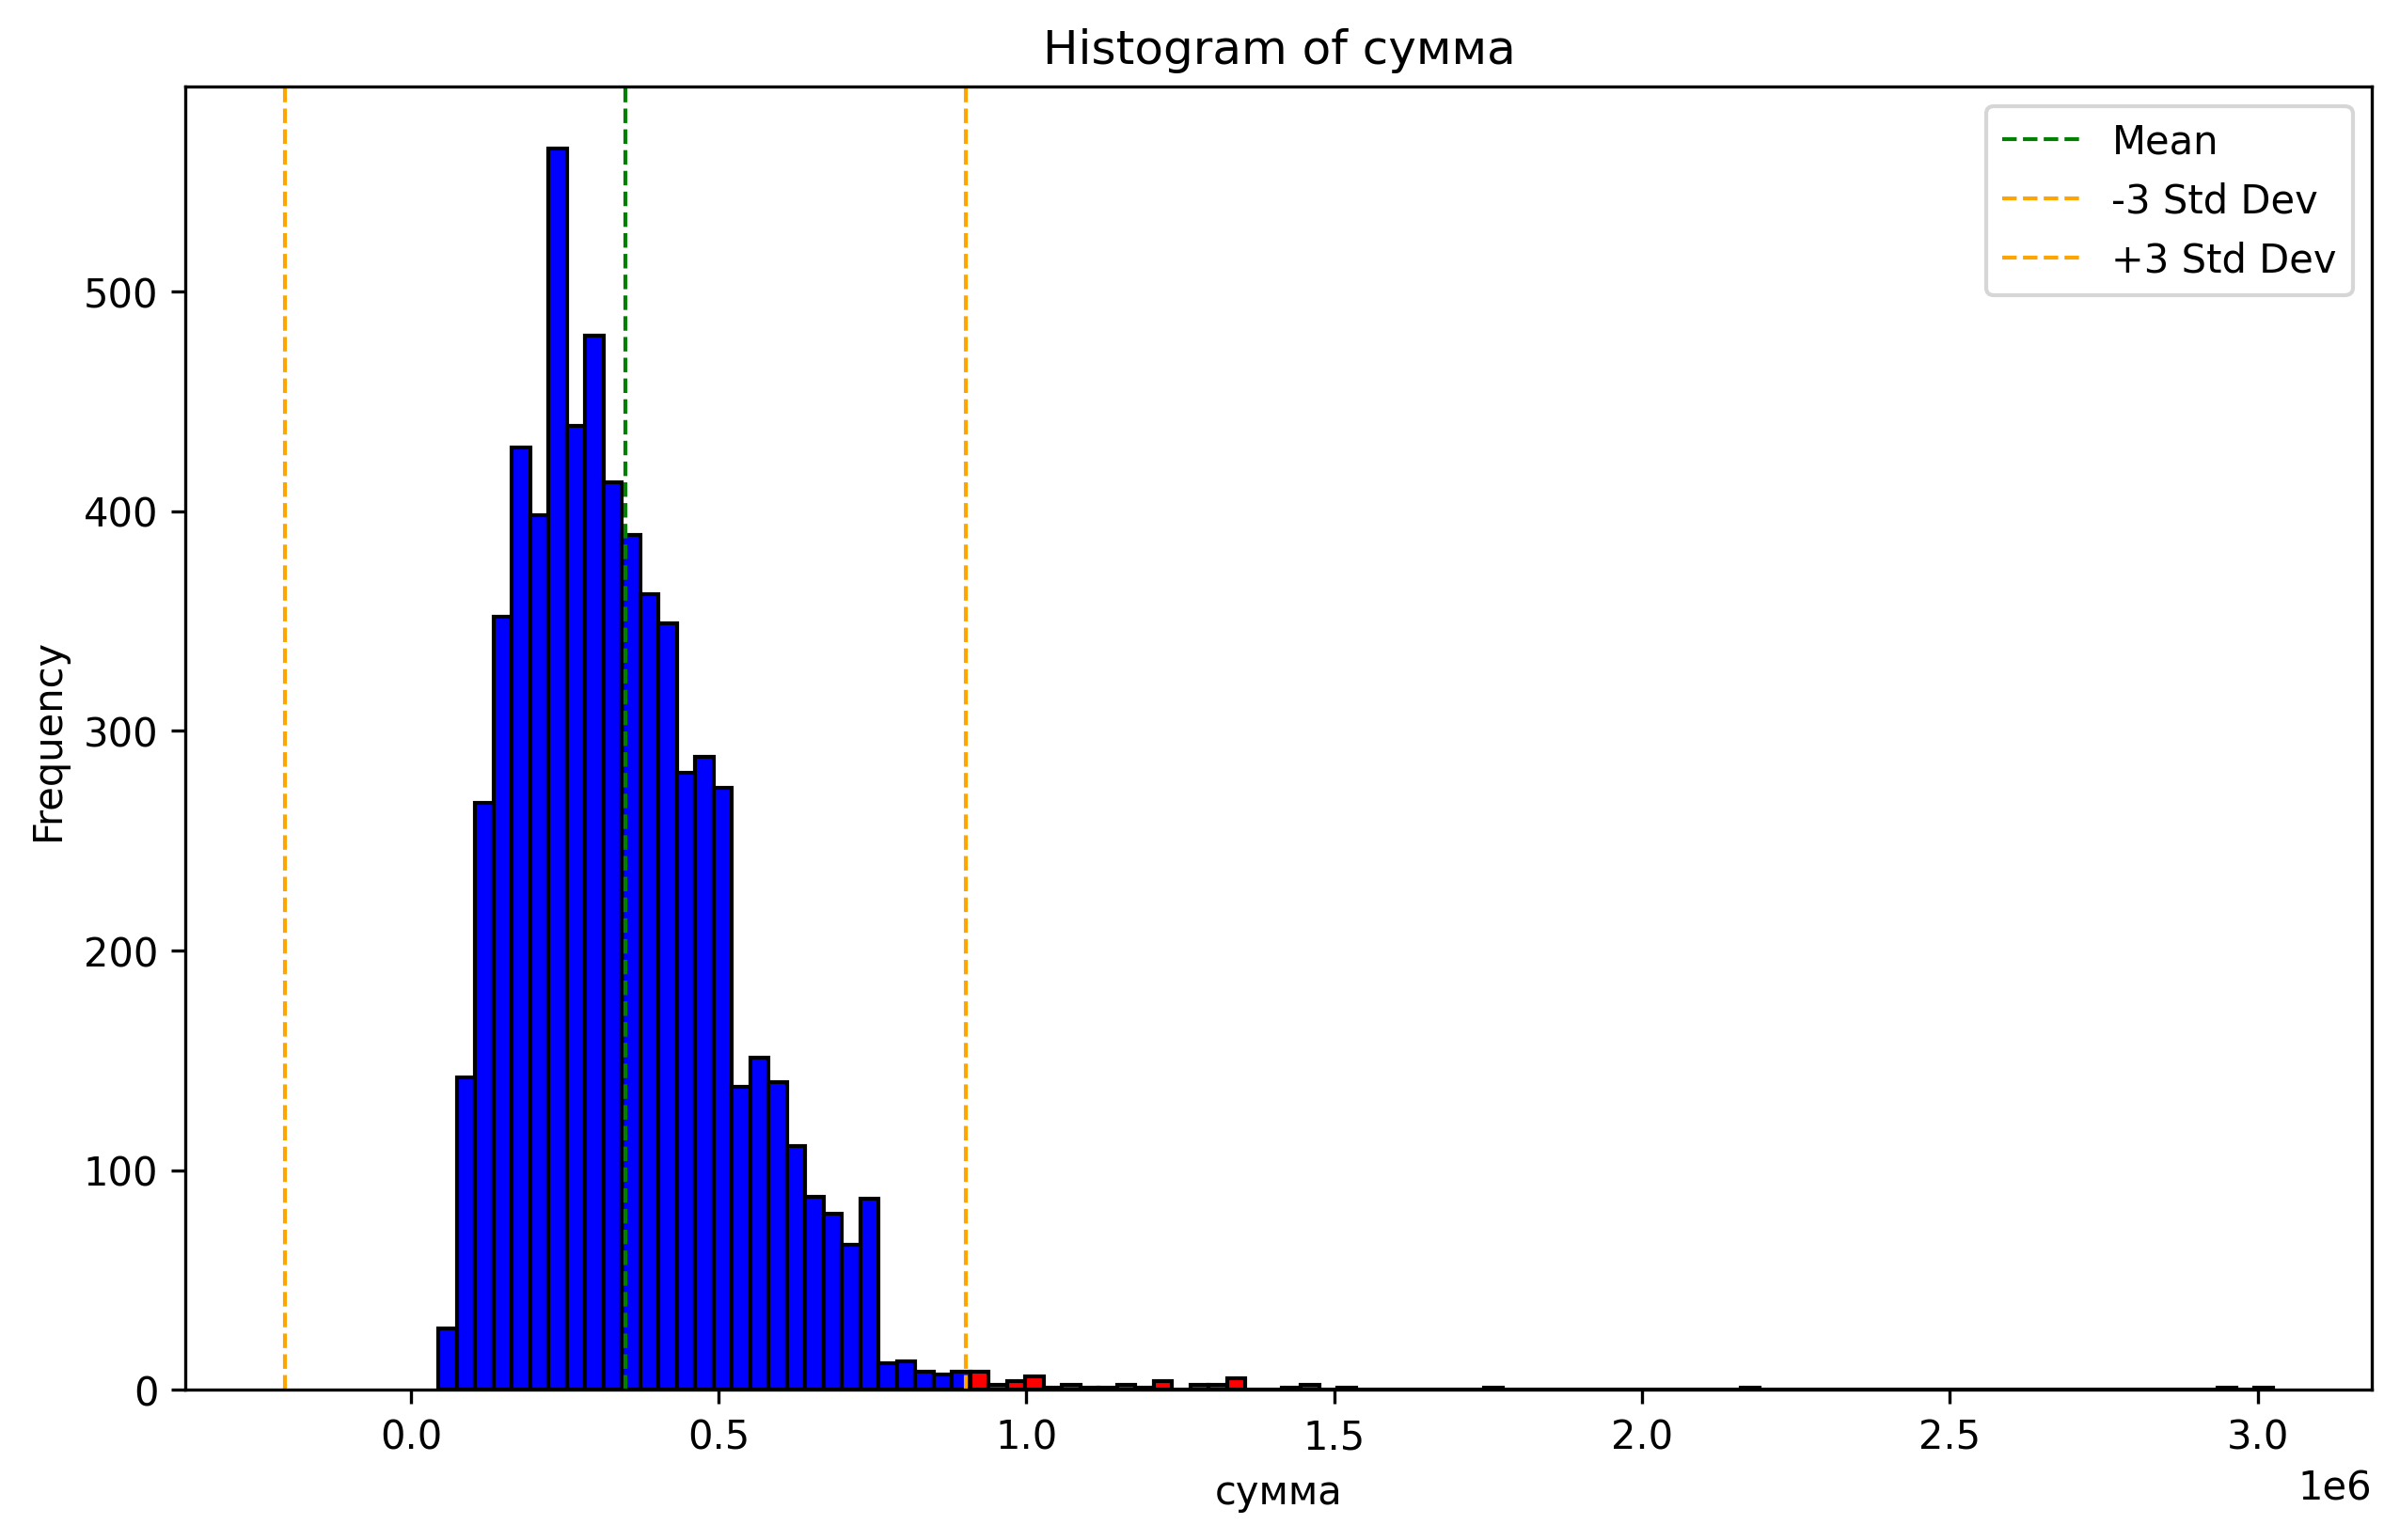

In [12]:
vis.plot_anomalies(loan_data, ["сумма"])

### Заменить аномальные значения

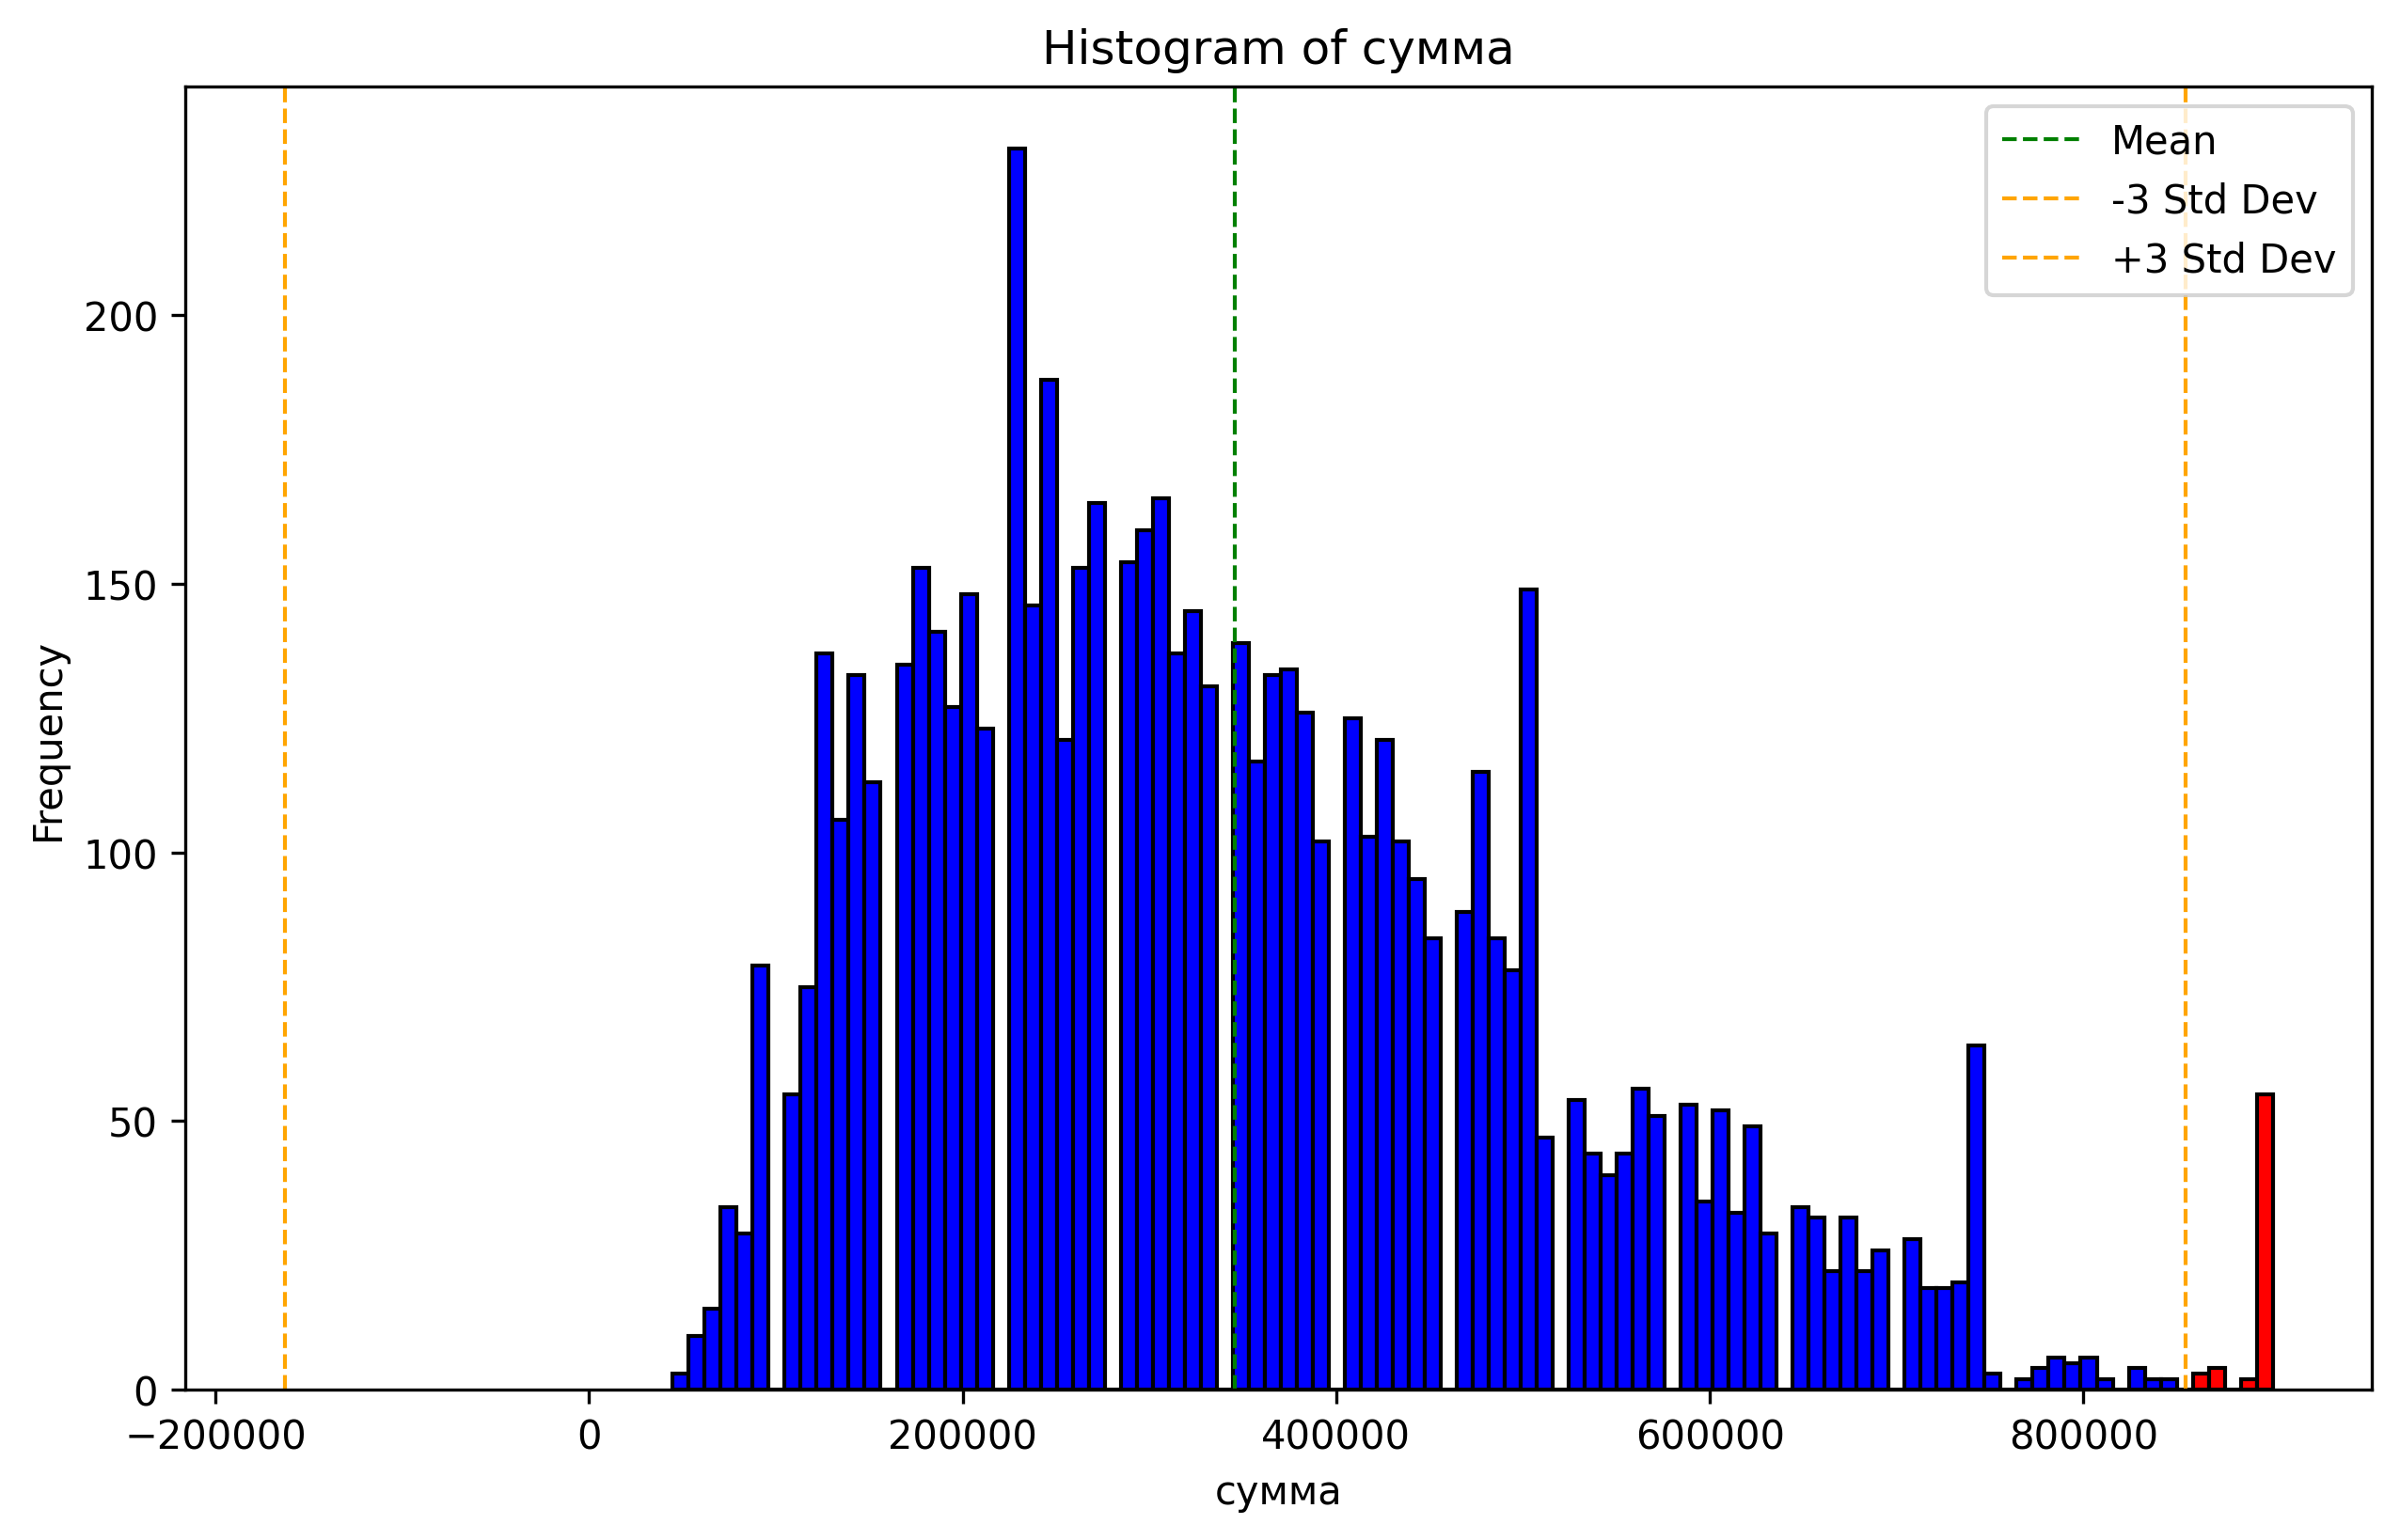

In [18]:
clipper_func = FunctionTransformer(
    transforms.clip_anomalies,
)
clipper = PandasTransformer(clipper_func, col_names=["сумма"])
pipe = make_pipeline(clipper)

vis.plot_anomalies(pipe.fit_transform(loan_data), ["сумма"])

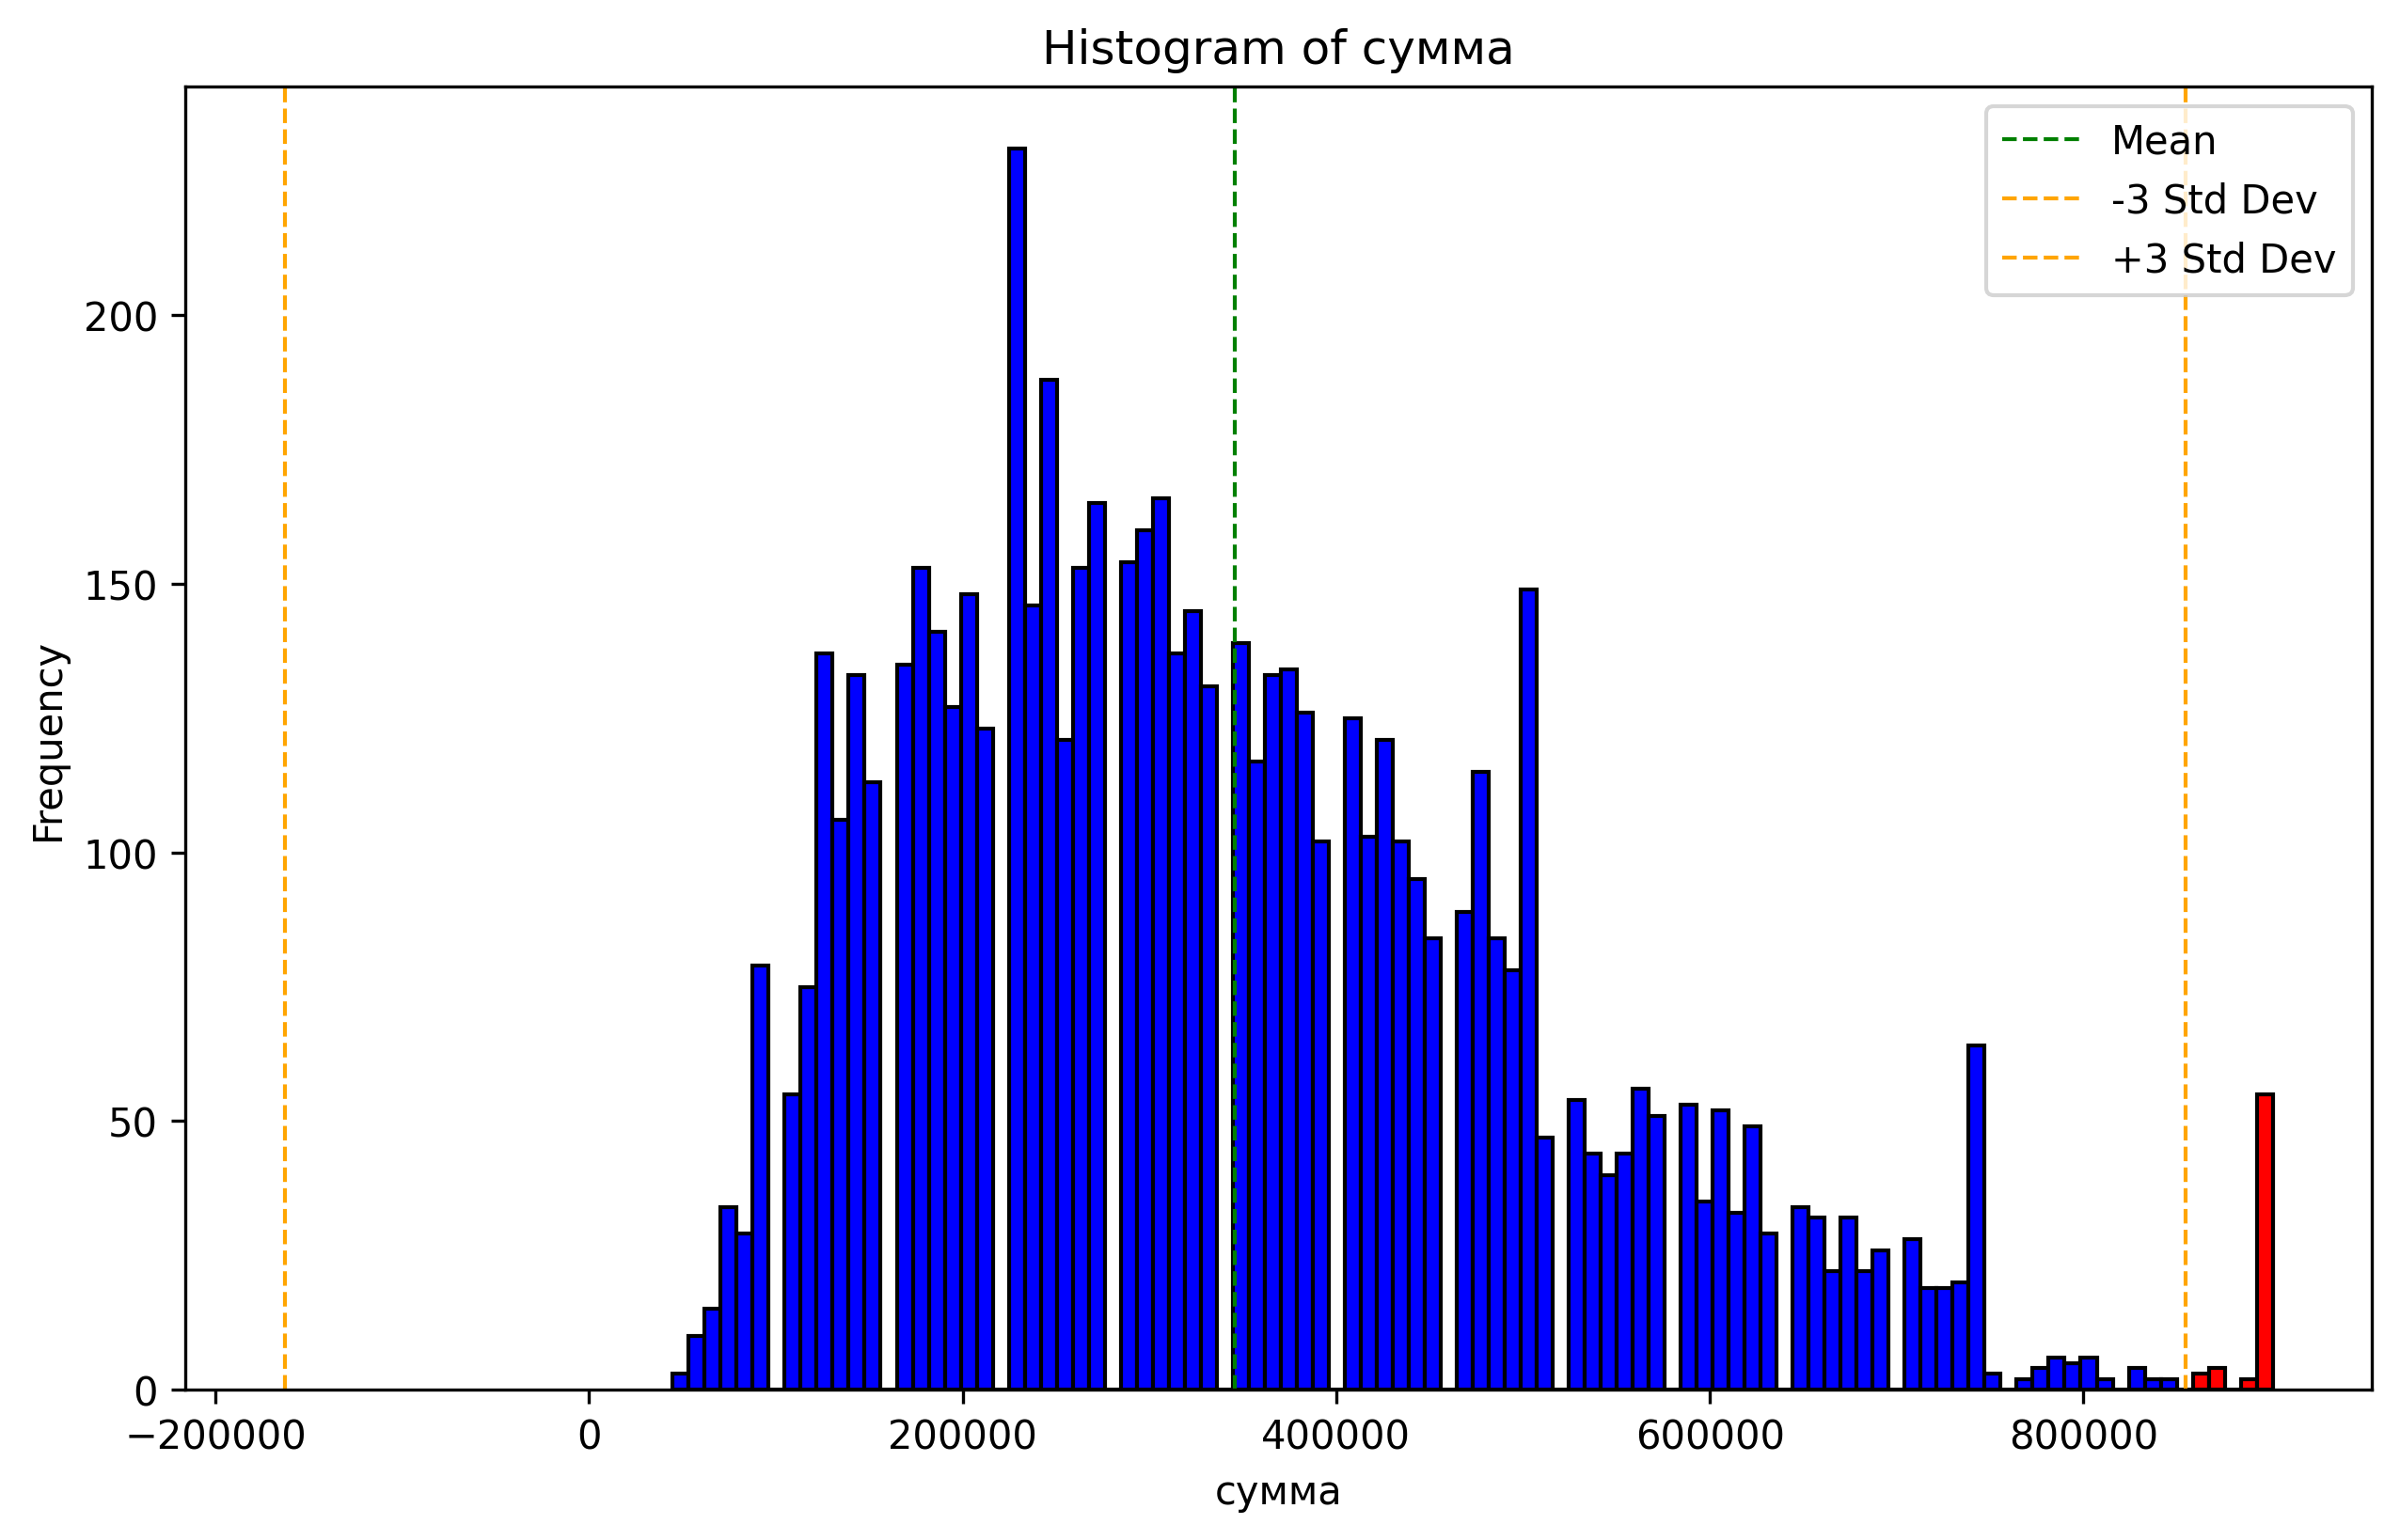

In [17]:
# Vis
cols = ["сумма"]
vis.plot_anomalies(transforms.clip_anomalies(loan_data[cols]), cols)

### Убрать аномальные значения

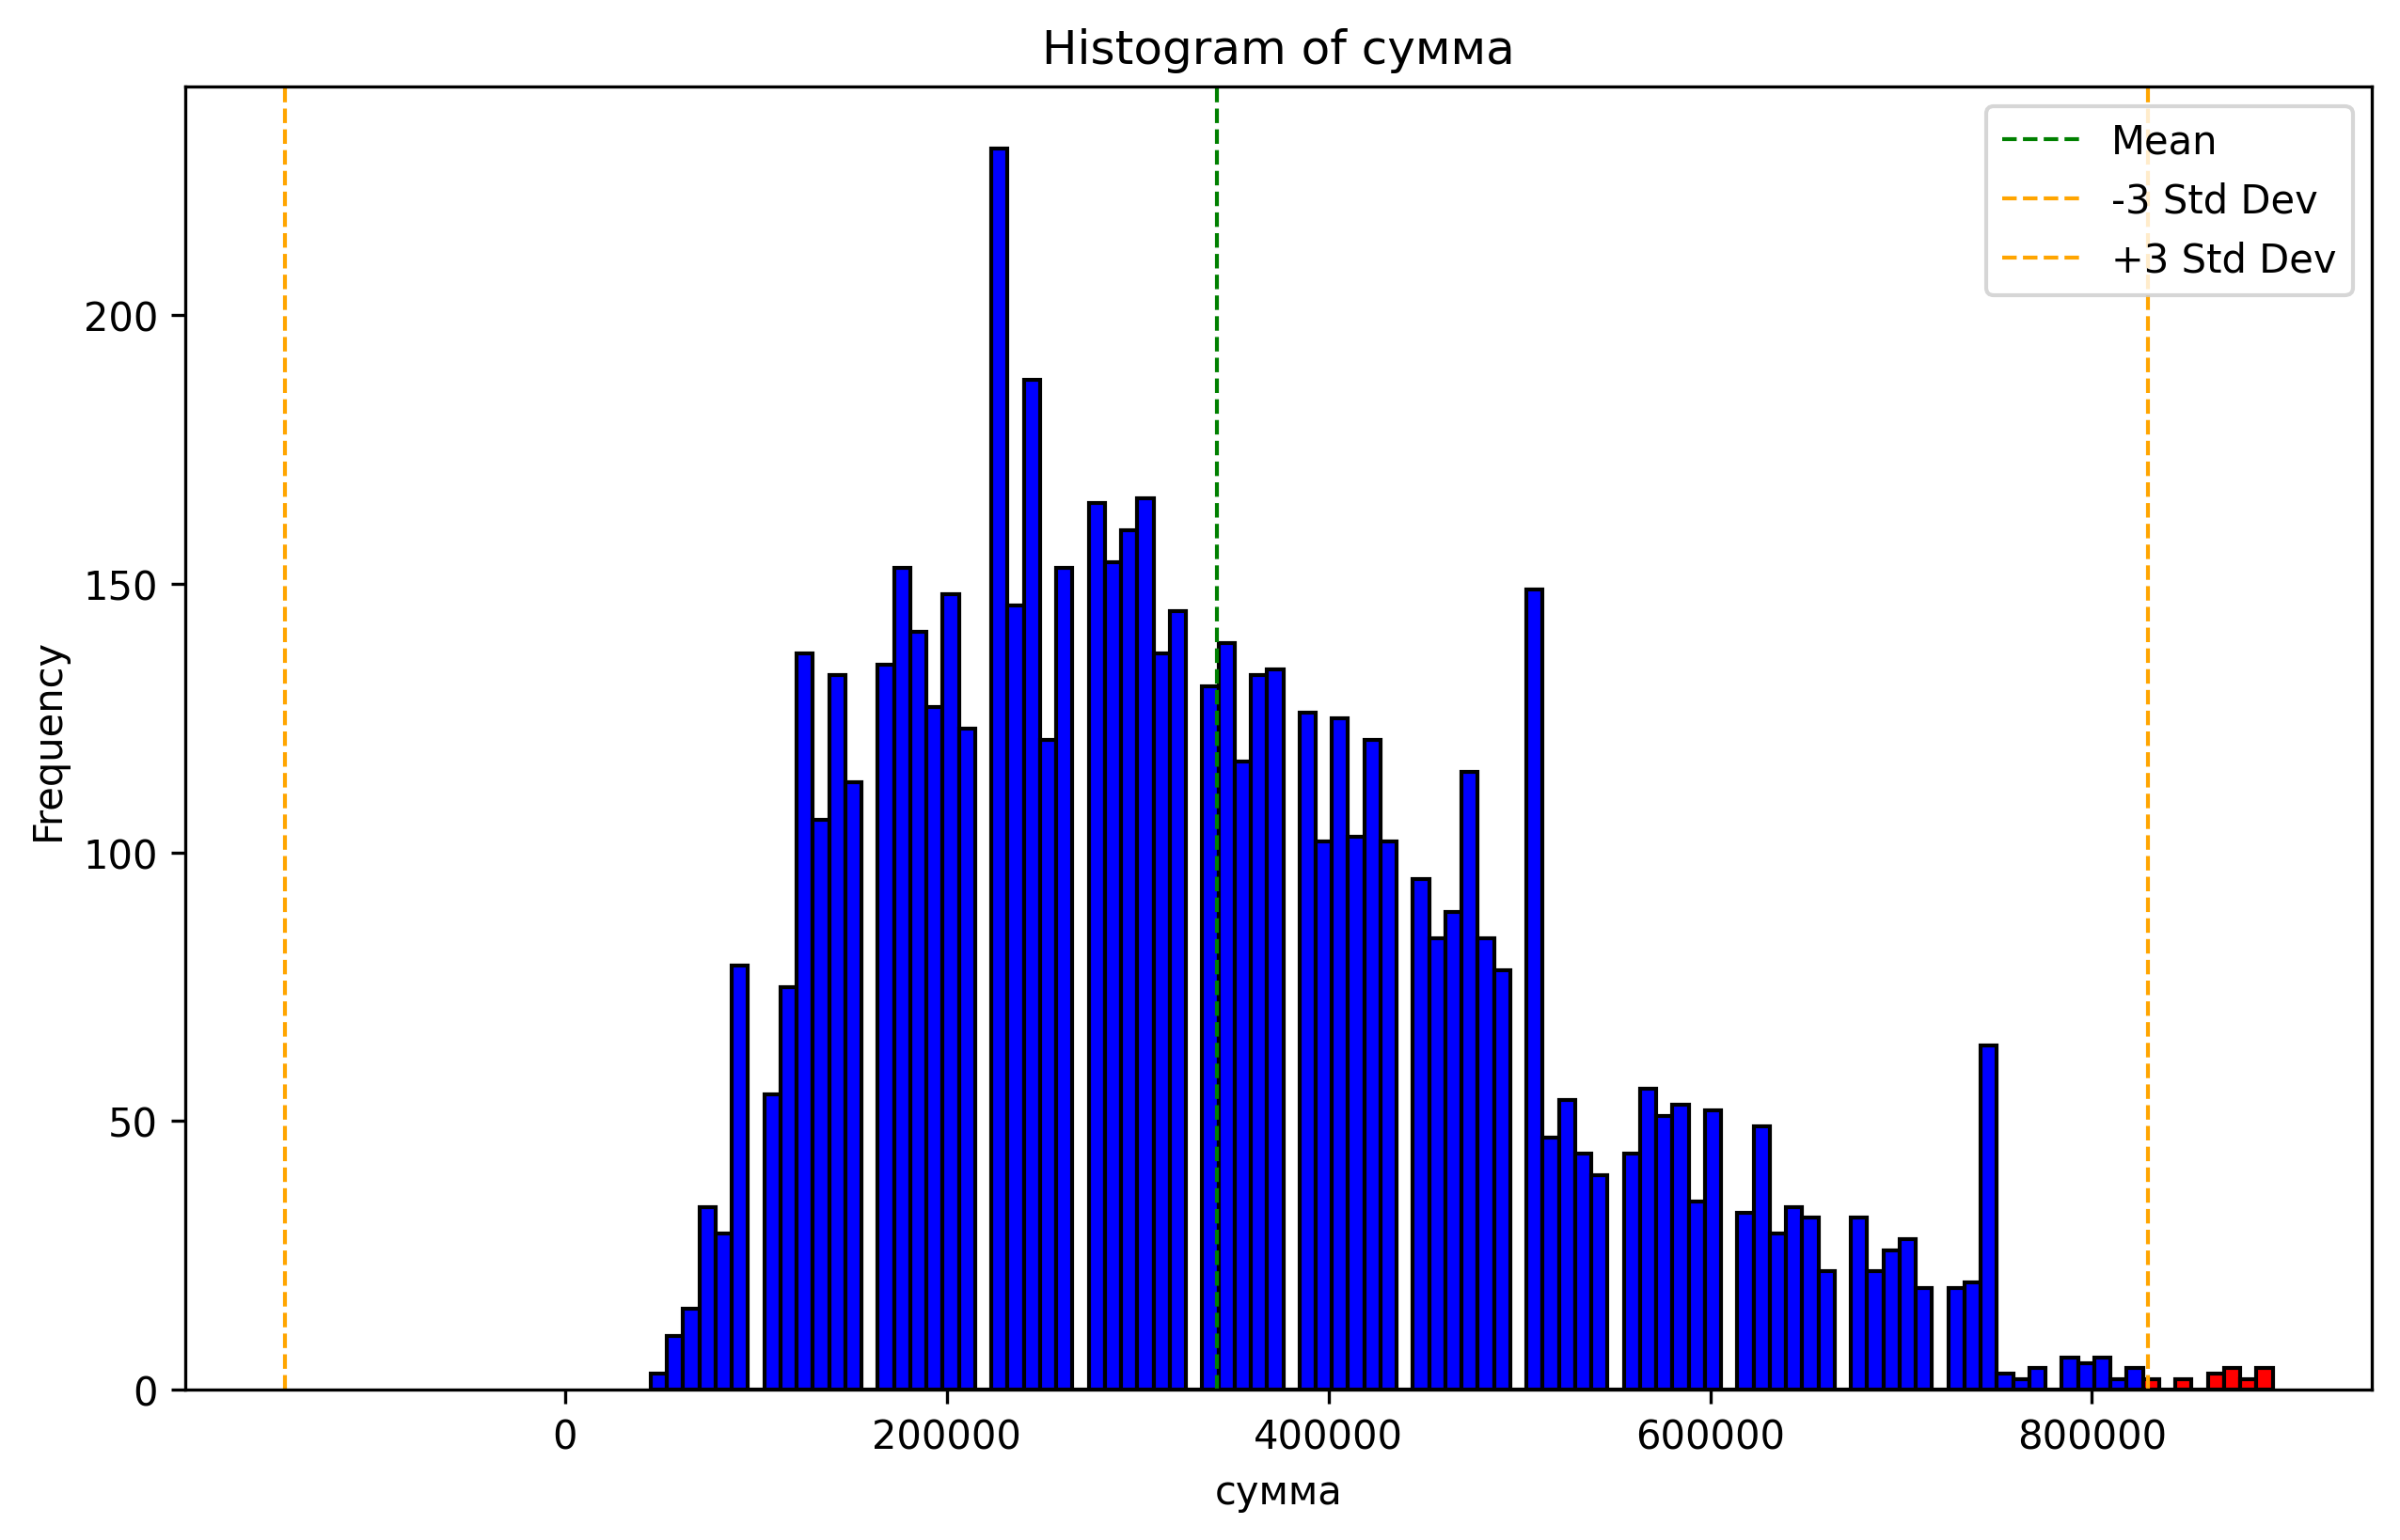

In [21]:
# В пайпе нельзя юзать

# Vis
cols = ["сумма"]
vis.plot_anomalies(transforms.remove_anomalies(loan_data[cols]), cols)

### Построить гистограммы

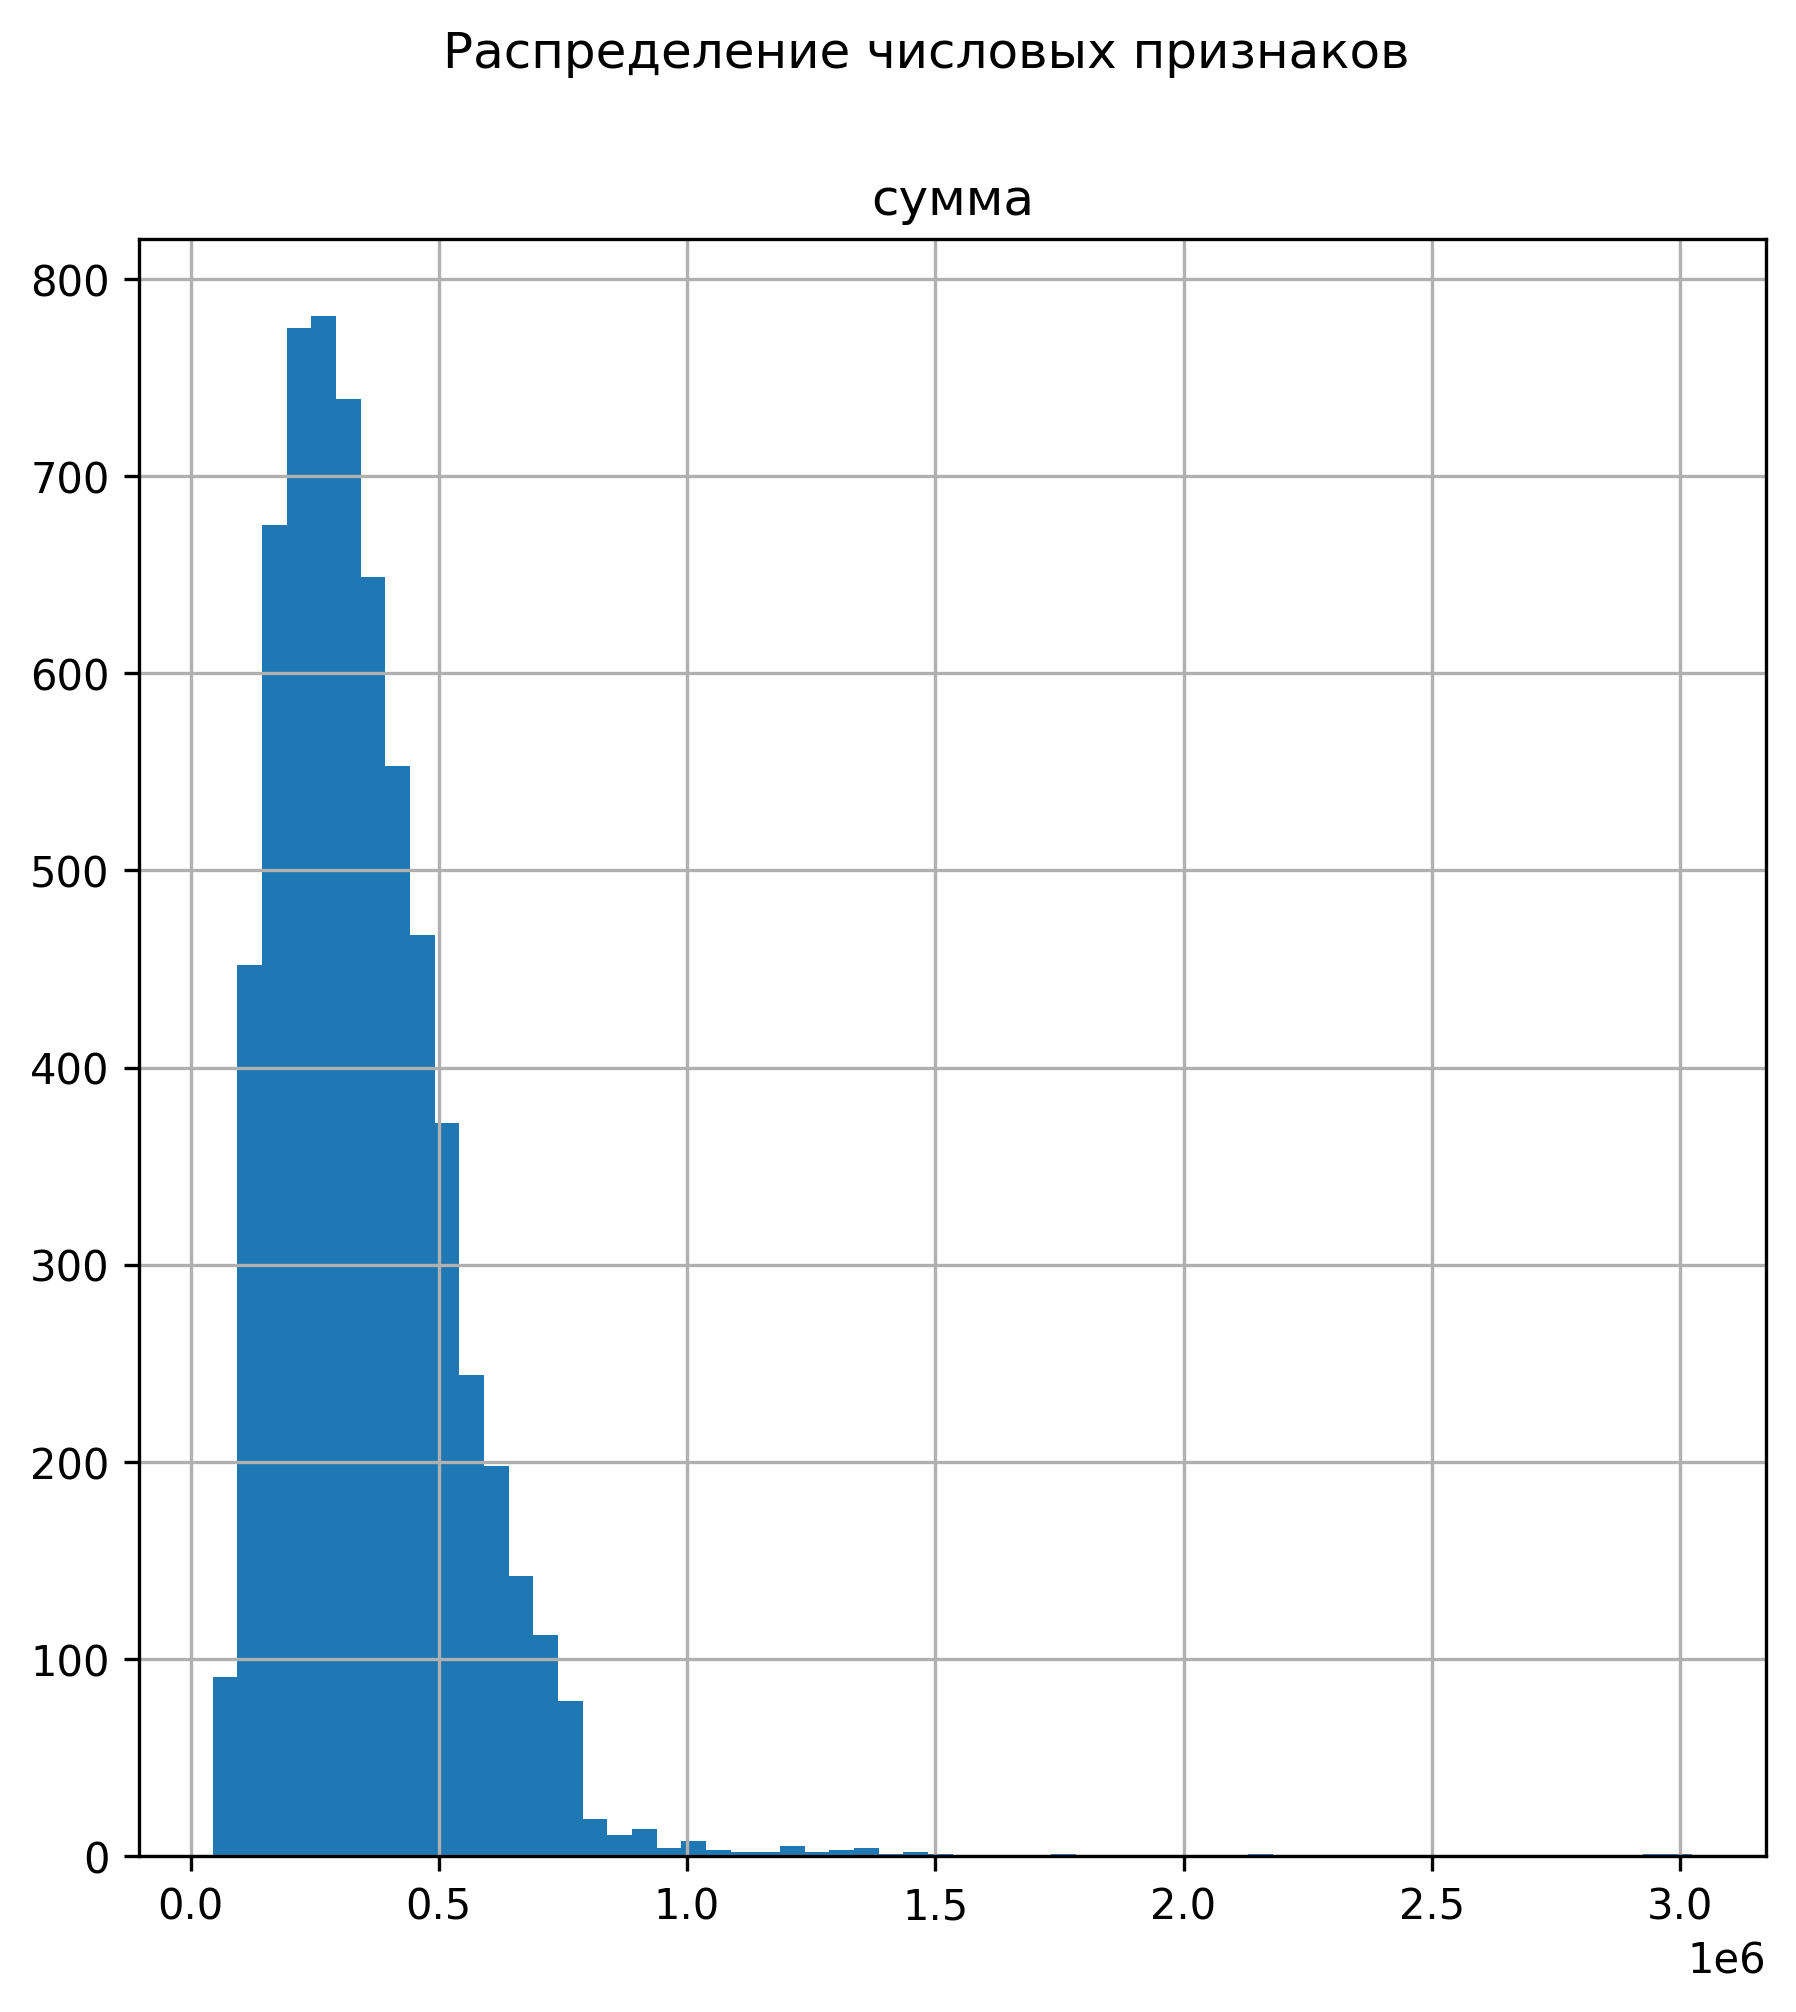

In [22]:
vis.plot_hist(loan_data, ["сумма"])

### Построить корреляционную матрицу

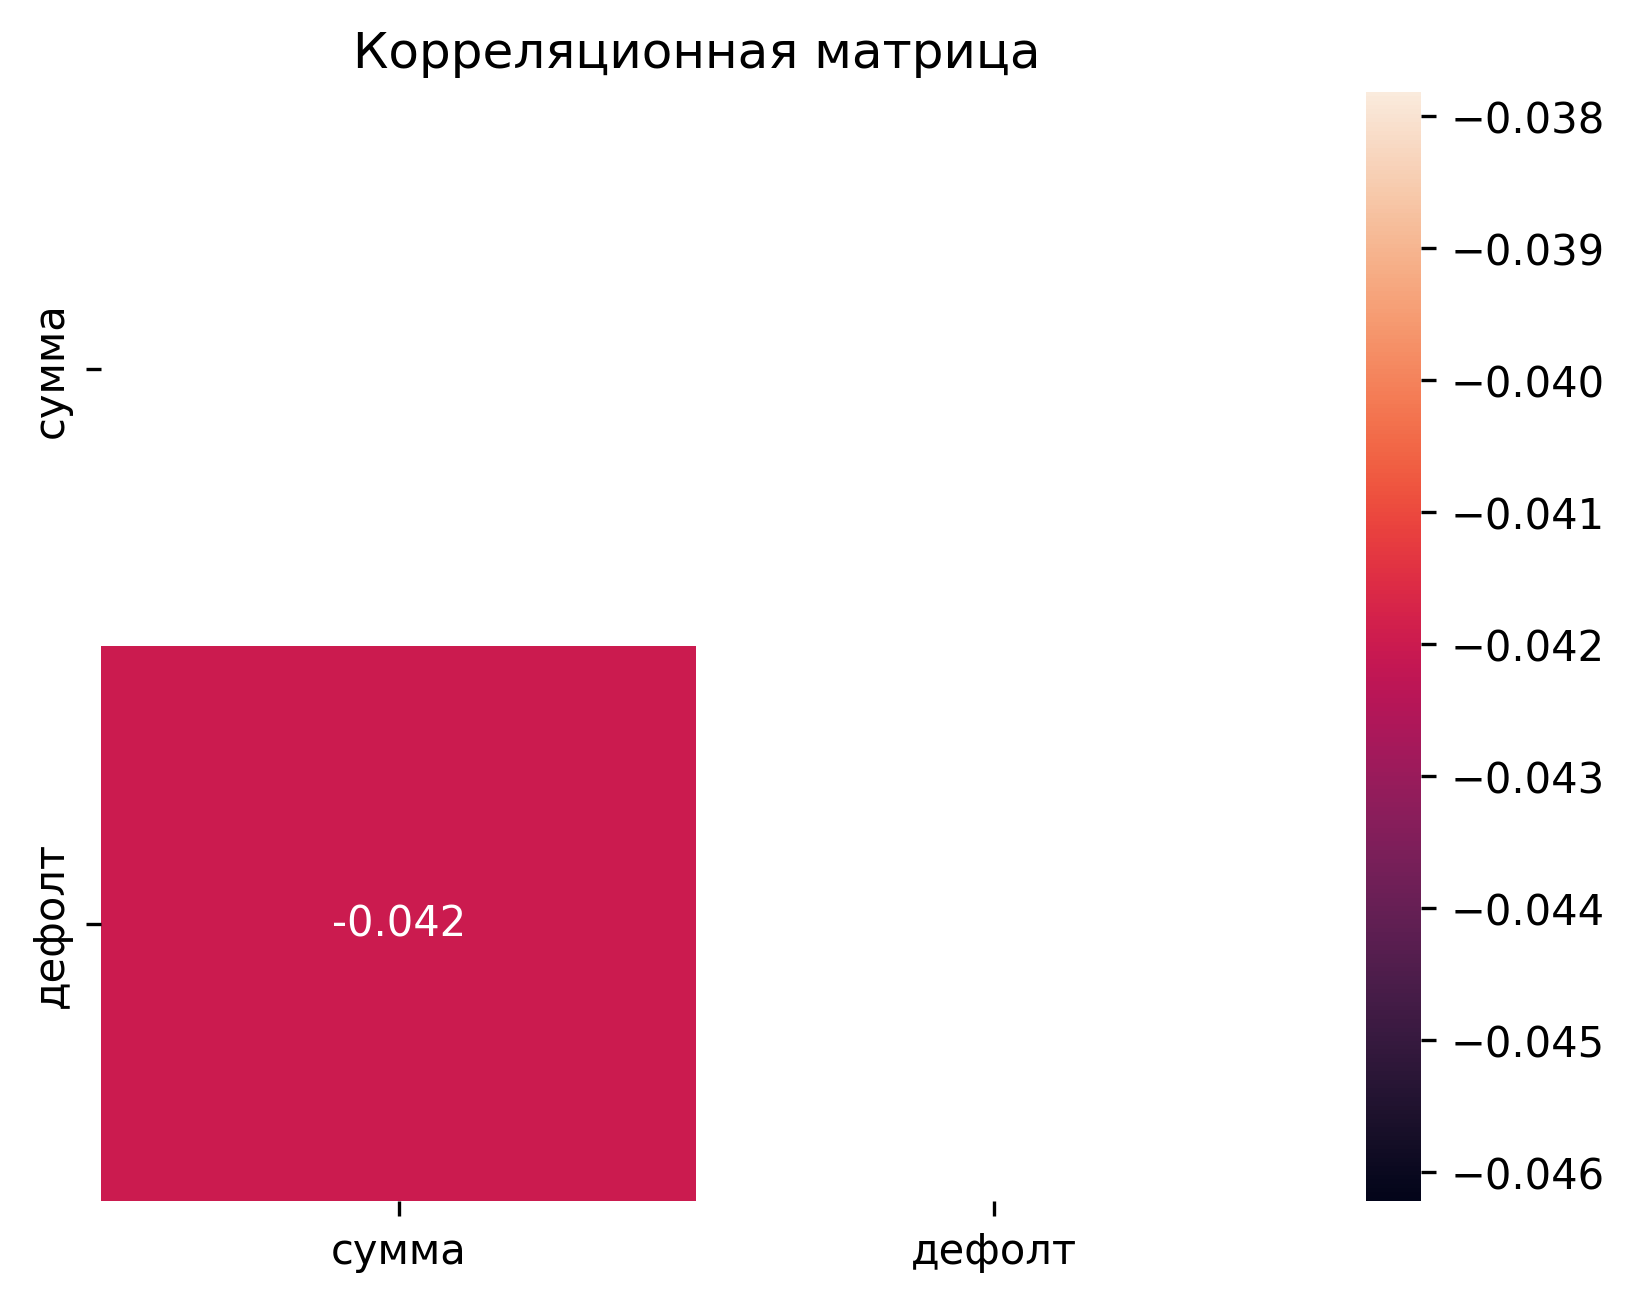

In [23]:
vis.plot_corr(loan_data, ["сумма", "дефолт"])

### Нормализовать числовые значения

In [24]:
scaler = StandardScaler()
scaler.fit_transform(loan_data[["сумма"]])

array([[-0.94245866],
       [        nan],
       [        nan],
       ...,
       [ 0.25137646],
       [ 1.33668111],
       [ 1.82506821]])

### Пропуски

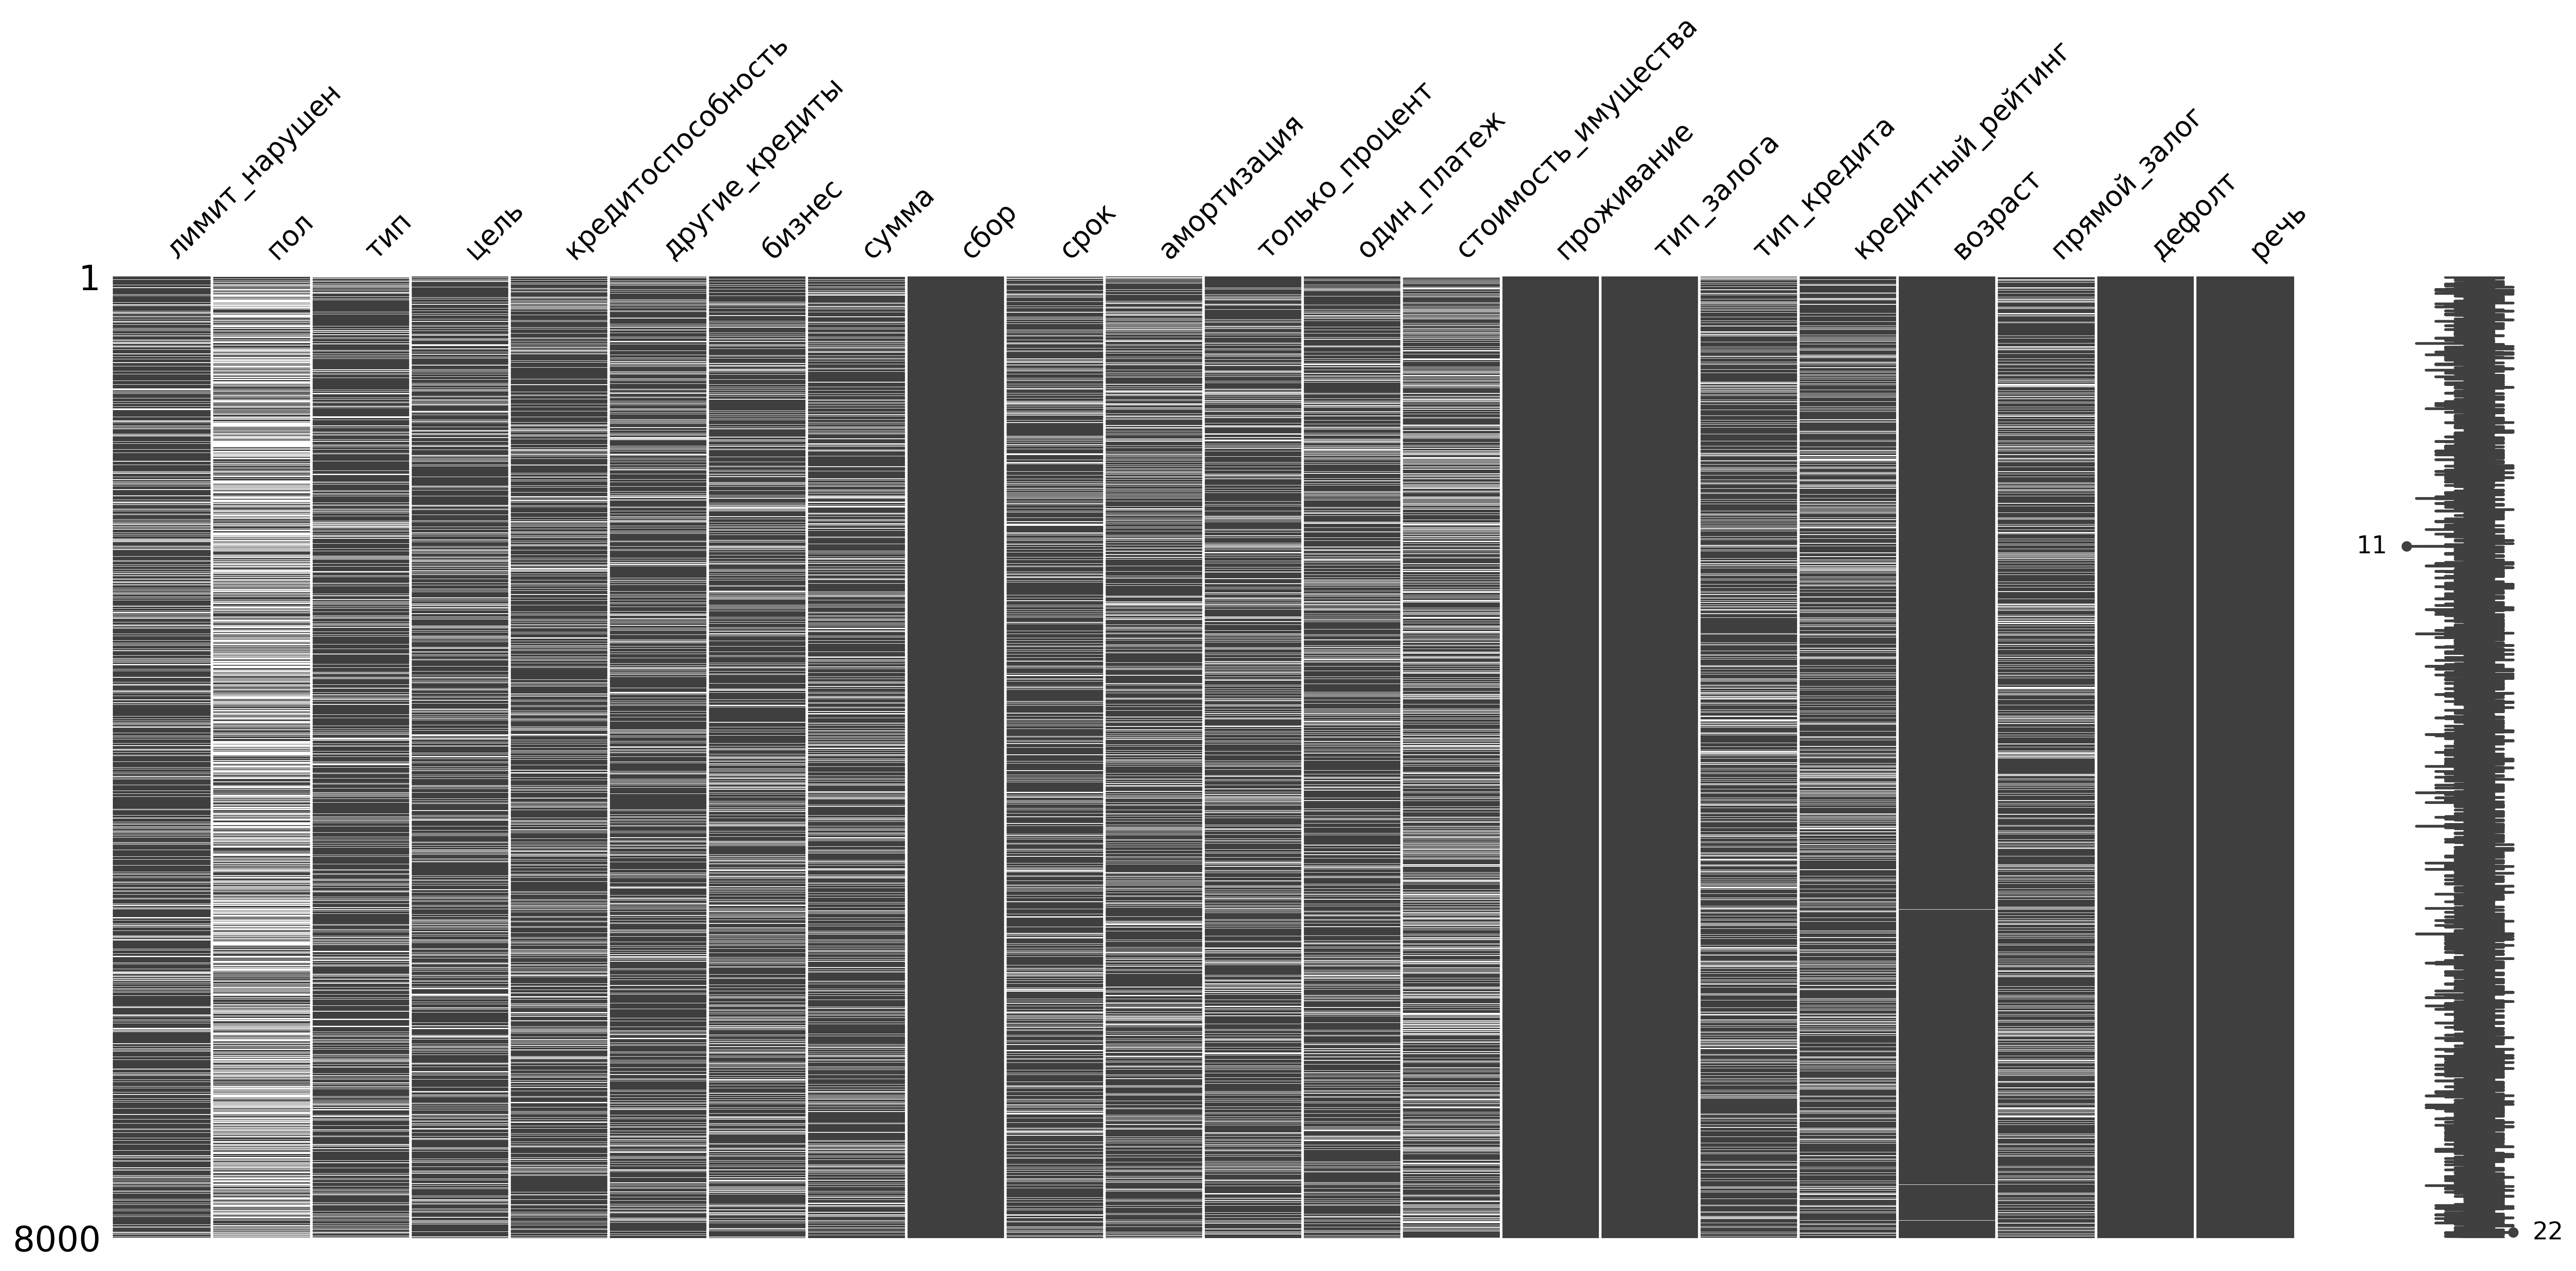

In [26]:
vis.plot_nan(loan_data)

### Заполнить пропуски

In [27]:
imputer = SimpleImputer(strategy="mean")
imputer.fit_transform(loan_data[["сумма"]])

array([[174765.26496798],
       [348441.59798949],
       [348441.59798949],
       ...,
       [394765.26496798],
       [594765.26496798],
       [684765.26496798]])

### Уникальные значения в категориальных столбцах

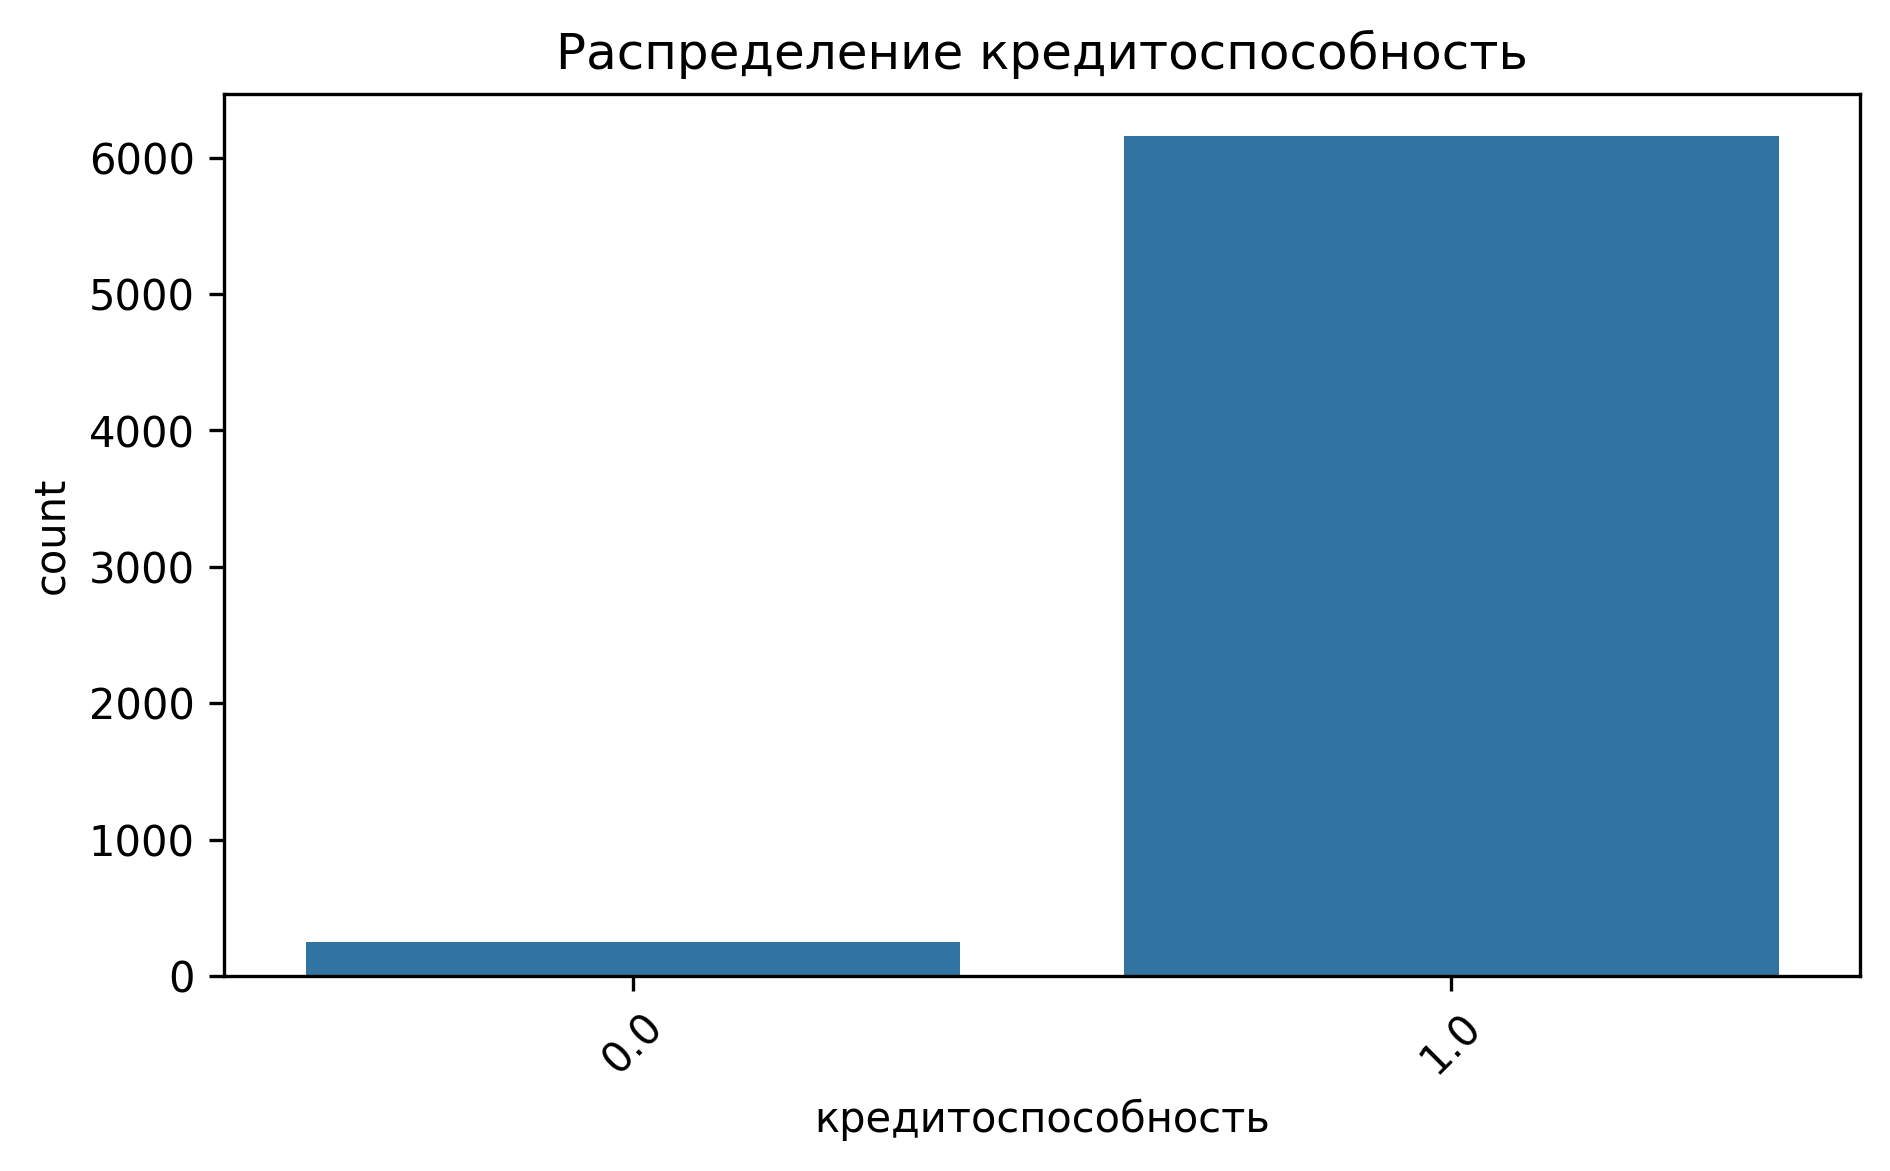

In [28]:
vis.plot_categorical_distributions(loan_data, ["кредитоспособность"])

In [29]:
vis.print_value_counts(loan_data, ["кредитоспособность"])

кредитоспособность
1.0    6157
0.0     249
Name: count, dtype: int64



### Заполнить пропуски в категориальных столбцах

In [4]:
cat_cols = ["кредитоспособность"]
pipe = PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols)
pipe.fit_transform(loan_data[cat_cols])

кредитоспособность
0                    1.0
1                    1.0
2                    1.0
3                    1.0
4                    1.0
...                  ...
7995                 1.0
7996                 1.0
7997                 1.0
7998                 1.0
7999                 1.0

[8000 rows x 1 columns]

### Закодировать категориальные признаки при помощи one hot encoding

In [8]:
# TODO doesn't work with pandas transformer
cat_cols = ["цель"]
pipe = PandasTransformer(OneHotEncoder(), cat_cols)
pipe.fit_transform(loan_data, cat_cols)

лимит_нарушен  пол  тип  \
0               0.0    м  3.0   
1               0.0  NaN  NaN   
2               0.0    м  3.0   
3               0.0  NaN  3.0   
4               0.0  NaN  3.0   
...             ...  ...  ...   
7995            0.0  NaN  3.0   
7996            NaN  NaN  NaN   
7997            0.0    м  3.0   
7998            NaN  NaN  NaN   
7999            0.0    ж  1.0   

                                                   цель  кредитоспособность  \
0     <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
1     <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
2     <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
3     <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
4     <Compressed Sparse Row sparse matrix of dtype ...                 NaN   
...                                                 ...                 ...   
7995  <Compressed Sparse Row sparse matrix of dtype ...                 NaN   
7996  <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
7997  <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
7998  <Compressed Sparse Row sparse matrix of dtype ...                 1.0   
7999  <Compressed Sparse Row sparse matrix of dtype ...                 1.0   

      другие_кредиты  бизнес          сумма                    сбор  \
0                NaN     0.0  174765.264968                  normal   
1                0.0     0.0            NaN                    want   
2                0.0     0.0            NaN                 regular   
3                0.0     0.0  474765.264968                  common   
4                0.0     0.0  384765.264968               excessive   
...              ...     ...            ...                     ...   
7995             0.0     0.0            NaN              not slight   
7996             0.0     1.0            NaN                    mean   
7997             NaN     0.0  394765.264968     Whole lotta nothin'   
7998             0.0     0.0  594765.264968  Total lack of presence   
7999             0.0     0.0  684765.264968               minuscule   

            срок  ...  один_платеж  стоимость_имущества  проживание  \
0     245.885949  ...          0.0        244488.111841         осн   
1     365.885949  ...          0.0                  NaN         осн   
2     365.885949  ...          NaN        364488.111841         осн   
3     365.885949  ...          0.0        894488.111841         осн   
4     365.885949  ...          0.0        504488.111841         осн   
...          ...  ...          ...                  ...         ...   
7995  125.885949  ...          0.0        744488.111841         осн   
7996  185.885949  ...          0.0        184488.111841         осн   
7997  365.885949  ...          0.0                  NaN         осн   
7998  365.885949  ...          0.0                  NaN         осн   
7999  365.885949  ...          0.0                  NaN         осн   

      тип_залога тип_кредита кредитный_рейтинг  возраст  прямой_залог дефолт  \
0            дом         2.0        709.508335    55-64           1.0      0   
1            дом         1.0        722.508335    55-64           NaN      0   
2            дом         1.0        785.508335    55-64           1.0      0   
3            дом         NaN        594.508335    35-44           1.0      0   
4            дом         NaN        589.508335    55-64           NaN      0   
...          ...         ...               ...      ...           ...    ...   
7995         дом         2.0               NaN    35-44           NaN      0   
7996         дом         1.0        796.508335      >74           1.0      0   
7997         дом         4.0        584.508335    25-34           1.0      1   
7998         дом         NaN        873.508335    35-44           1.0      0   
7999         дом         2.0               NaN    35-44           1.0     

### Закодировать категориальные признаки при помощи label encoding

In [12]:
cat_cols = ["пол"]
cat_encoder = ColumnTransformer(
    [("encoder", OrdinalEncoder(), cat_cols)],
    remainder="passthrough",
)
pipe = PandasTransformer(OrdinalEncoder(), cat_cols)
pipe.fit_transform(loan_data, cat_cols)[cat_cols]

пол
0     1.0
1     NaN
2     1.0
3     NaN
4     NaN
...   ...
7995  NaN
7996  NaN
7997  1.0
7998  NaN
7999  0.0

[8000 rows x 1 columns]

### Связь категориальных переменных и таргета

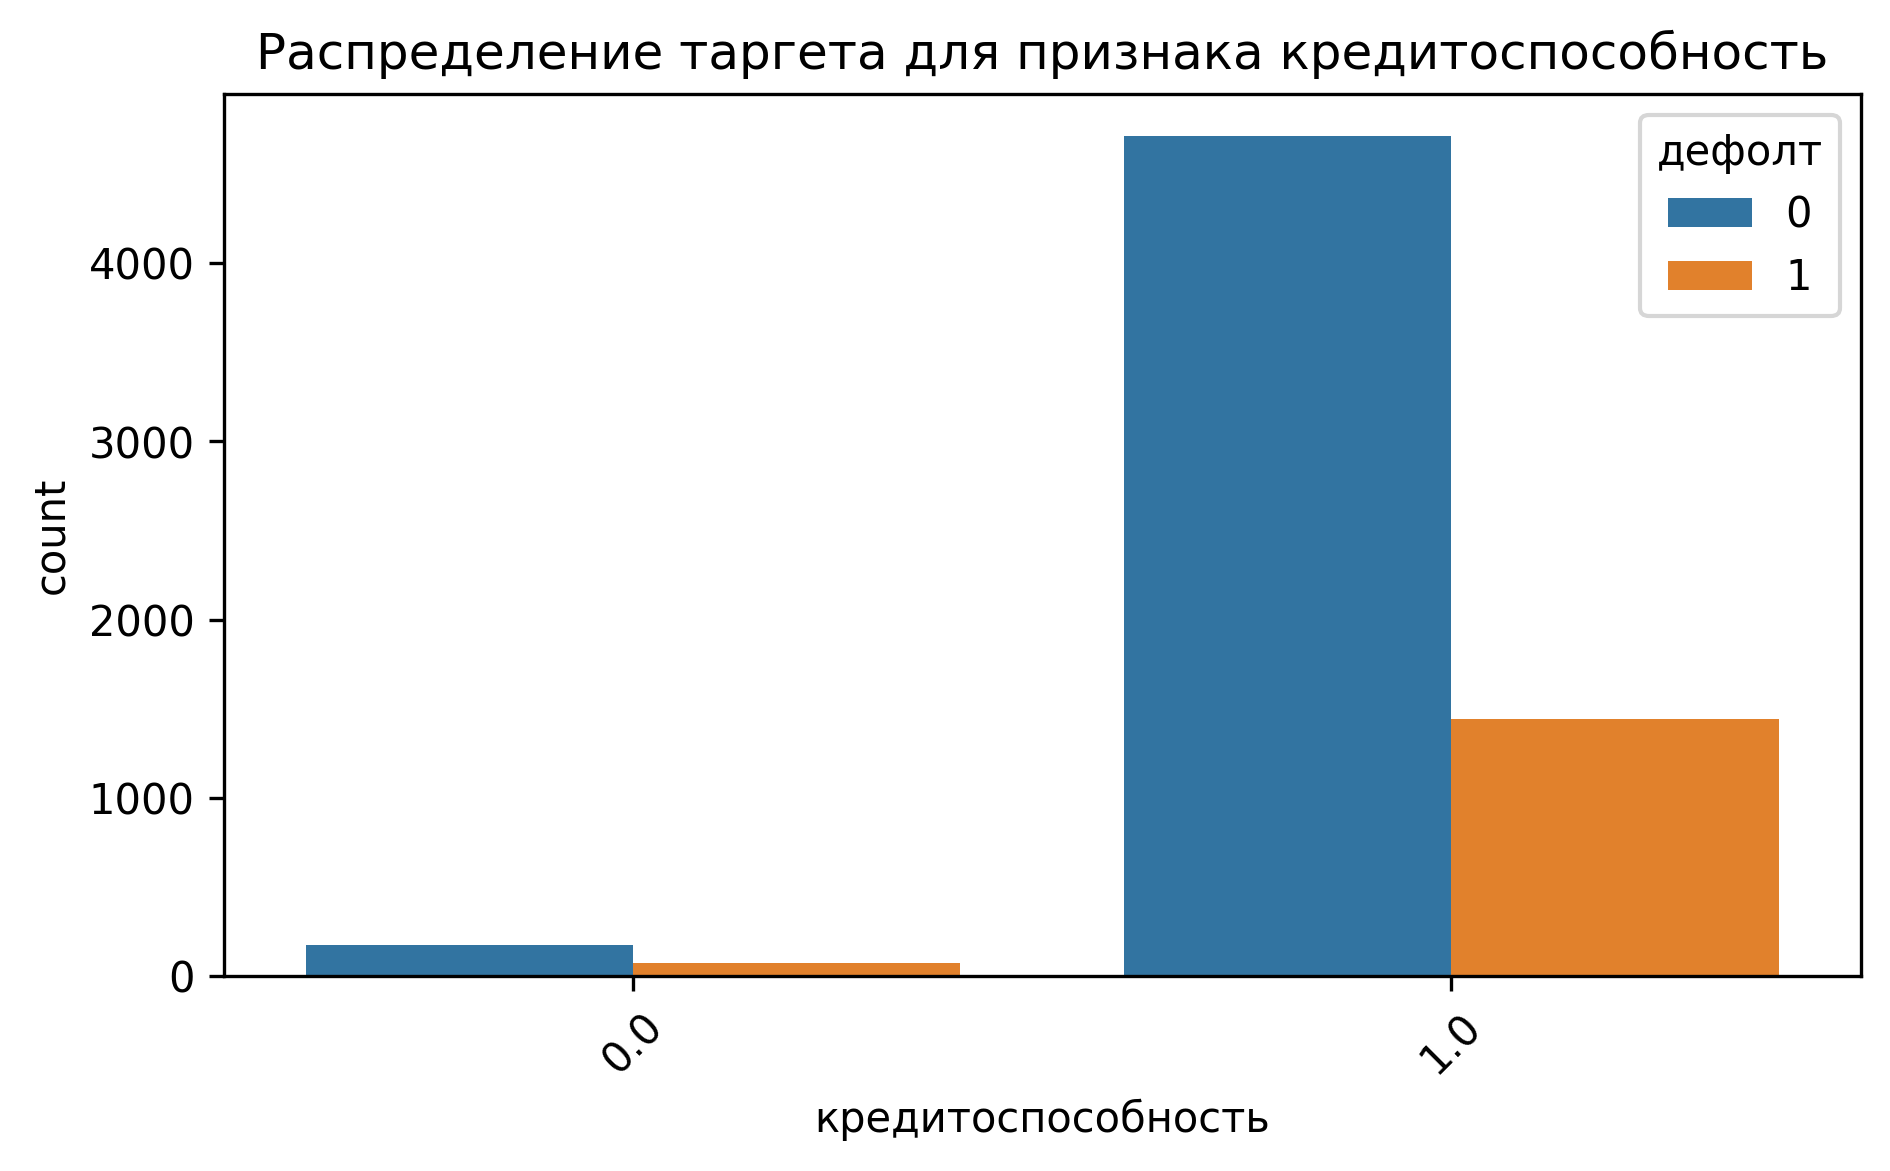

In [13]:
vis.visualize_cat_and_target(loan_data, ["кредитоспособность"])

# Модель

### Обучить модель без разделения

In [14]:
def train_log_reg(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    float_cols = X.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", transforms.FeatSelector(float_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    modeling.print_metrics(y_true=y, y_pred=pred)


train_log_reg(loan_data)

Accuracy: 0.812
Precision: 0.744
Recall: 0.314
f1: 0.441


/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Разделить выборку на обучающее и тестовое множество

In [ ]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42)

### Сделать отчет о классификации

In [ ]:
# Модифицируйте modeling.print_metrics

### Разделить выборку на обучающее и тестовое множество со стратификацией

In [19]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42, stratify=loan_data[TARGET])

### Обучить модель с разделением

In [28]:
def train_model_with_test(data: pd.DataFrame) -> Pipeline:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    float_cols = list(X_train.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    pipe = make_pipeline(
        transforms.FeatSelector(float_cols + cat_cols),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
        PandasTransformer(OrdinalEncoder(), cat_cols),
        PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()
    return pipe


pipe = train_model_with_test(loan_data)
model_path = Path("output/model.pkl")
model_path.parent.mkdir(exist_ok=True)
joblib.dump(pipe, model_path)

Train
Accuracy: 0.817
Precision: 0.746
Recall: 0.307
f1: 0.435

Test
Accuracy: 0.798
Precision: 0.761
Recall: 0.284
f1: 0.414



/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['output/model.pkl']

### Обучить модель с настройкой гиперпараметров

In [27]:
def grid_search(data: pd.DataFrame) -> Pipeline:
    def get_model(float_cols: list[str], cat_cols: list[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(
            transforms.FeatSelector(float_cols + cat_cols),
            PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
            PandasTransformer(OrdinalEncoder(), cat_cols),
            PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
            RandomForestClassifier(random_state=42, **kwargs),
        )

    df_train, df_test = modeling.get_train_test(data)
    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)
    float_cols = list(X_train.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    params = {
        "bootstrap": [True, False],
        # "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "max_features": ["auto", "sqrt"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    for kwargs in tqdm(ParameterGrid(params)):
        cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
        cur_pipe.fit(X_train, y_train)
        pred = cur_pipe.predict(X_test)
        metric = f1_score(y_true=y_test, y_pred=pred)
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
    cur_pipe.fit(X_train, y_train)

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")
    return pipe


pipe = grid_search(loan_data)
model_path = Path("output/model.pkl")
model_path.parent.mkdir(exist_ok=True)
joblib.dump(pipe, model_path)

100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Best metric: 0.541
Best kwargs: {'bootstrap': False}


['output/model.pkl']

### Обучить модель с настройкой гиперпараметров на кросс вале

In [ ]:
def grid_search_cv(data: pd.DataFrame) -> Pipeline:
    X, y = modeling.get_xy(data)
    float_cols = list(X.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    params = {
        "randomforestclassifier__bootstrap": [True, False],
        # "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "randomforestclassifier__max_features": ["auto", "sqrt"],
        # "randomforestclassifier__min_samples_leaf": [1, 2, 4],
        # "randomforestclassifier__min_samples_split": [2, 5, 10],
        # "randomforestclassifier__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    model = make_pipeline(
        transforms.FeatSelector(float_cols + cat_cols),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
        PandasTransformer(OrdinalEncoder(), cat_cols),
        PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
        RandomForestClassifier(random_state=42),
    )
    pipe = GridSearchCV(model, param_grid=params)
    pipe.fit(X, y)
    print("Best params:", pipe.best_params_)
    print("Best score:", pipe.best_score_)
    return pipe


pipe = grid_search_cv(loan_data)
model_path = Path("output/model.pkl")
model_path.parent.mkdir(exist_ok=True)
joblib.dump(pipe, model_path)

Best params: {'randomforestclassifier__bootstrap': True}
Best score: 0.841625


['output/model.pkl']

### Обучить модель с настройкой гиперпараметров на кросс вале (для кастомной метрики)

In [29]:
def grid_search_cv_custom(data: pd.DataFrame, n_splits: int = 3) -> Pipeline:
    def get_model(float_cols: list[str], cat_cols: list[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(
            transforms.FeatSelector(float_cols + cat_cols),
            PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
            PandasTransformer(OrdinalEncoder(), cat_cols),
            PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
            RandomForestClassifier(random_state=42, **kwargs),
        )

    X, y = modeling.get_xy(data)
    float_cols = list(X.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]
    params = {
        "bootstrap": [True, False],
        # "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "max_features": ["auto", "sqrt"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    folds = list(KFold(n_splits=n_splits).split(X))

    for kwargs in tqdm(ParameterGrid(params)):
        fold_metrics: list[float] = []

        for train_i, test_i in folds:
            X_train, y_train = X.loc[train_i], y.loc[train_i]
            X_test, y_test = X.loc[test_i], y.loc[test_i]

            cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
            cur_pipe.fit(X_train, y_train)
            pred = cur_pipe.predict(X_test)
            cur_metric = business.profit(y_true=y_test, y_pred=pred, feats=X_test)
            fold_metrics.append(cur_metric)

        metric = float(np.mean(fold_metrics))
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    assert best_kwargs is not None
    pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **best_kwargs)
    pipe.fit(X, y)

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")
    return pipe


pipe = grid_search_cv_custom(loan_data)
model_path = Path("output/model.pkl")
model_path.parent.mkdir(exist_ok=True)
joblib.dump(pipe, model_path)

100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Best metric: 63402501.092
Best kwargs: {'bootstrap': False}


['output/model.pkl']

### Разработка текстовых фич

In [ ]:
# transforms.TextFeaturesExtractor


import joblib


def train_text(data: pd.DataFrame) -> None:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    cols = list(X_train.select_dtypes(exclude=object).columns)
    cols.append("речь")

    pipe = make_pipeline(
        transforms.FeatSelector(cols),
        transforms.TextFeaturesExtractor(text_feat="речь"),
        SimpleImputer(strategy="mean"),
        StandardScaler(),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()


train_text(loan_data)

# Бизнес

### Спроектировать бизнес-метрику для модели

In [ ]:
# Наша реализация - business.profit